In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.cuda.is_available()

True

In [3]:
# download dataset
data_set_folder = '/kaggle/working'
# fashion mnist dataset
fmnist = datasets.FashionMNIST(data_set_folder, download=True, train=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.04MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.71MB/s]


In [4]:
train_fmnist = fmnist.data
target_fmnist = fmnist.targets

In [5]:
# fetch datasset
class FmnistData(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

# load dataset
def get_data():
    train = FmnistData(train_fmnist, target_fmnist)
    train_dl = DataLoader(train, batch_size=30, shuffle=True)
    return train_dl

# define model
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10) # 10 classes
    ).to(device)
    # calculate loss
    loss_func = nn.CrossEntropyLoss()
    # optimizer
    optimizer = SGD(model.parameters(), lr=0.01)
    return model, loss_func, optimizer

# train batch
def train_batch(x, y, model, optimizer, loss_func):
    model.train()
    prediction = model(x)
    batch_loss = loss_func(prediction, y)
    batch_loss.backward()
    # weight update
    optimizer.step()
    # reset previous grads
    optimizer.zero_grad()
    return batch_loss.item()

# calculate accuracy
@torch.no_grad() # disable grads
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

# train the model without data scale
train_dl = get_data()
model, loss_func, optimizer = get_model()
losses, accuracies = [], []
for epoch in range(10):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    # training
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_func)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    # evaluation
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


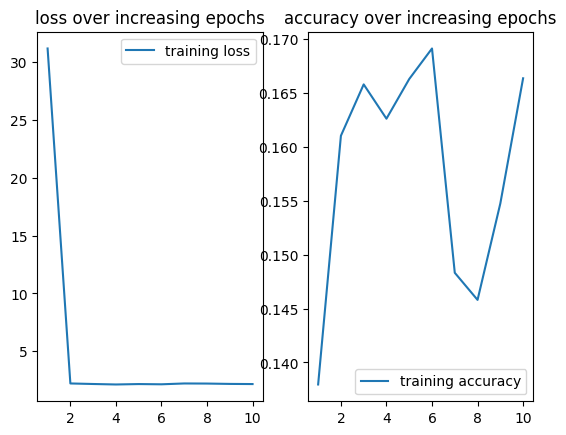

In [6]:
epochs = np.arange(10) + 1
plt.subplot(121)
plt.title('loss over increasing epochs')
plt.plot(epochs, losses, label='training loss')
plt.legend()
plt.subplot(122)
plt.title('accuracy over increasing epochs')
plt.plot(epochs, accuracies, label='training accuracy')
plt.legend()

## Scaling Data

In [7]:
# fetch datasset
class FmnistData(Dataset):
    def __init__(self, x, y):
        x = x.float()/255 # scale data
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)
        
# load dataset
def get_data():
    train = FmnistData(train_fmnist, target_fmnist)
    train_dl = DataLoader(train, batch_size=30, shuffle=True)
    return train_dl

# define model
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10) # 10 classes
    ).to(device)
    # calculate loss
    loss_func = nn.CrossEntropyLoss()
    # optimizer
    optimizer = SGD(model.parameters(), lr=0.01)
    return model, loss_func, optimizer

# train batch
def train_batch(x, y, model, optimizer, loss_func):
    model.train()
    prediction = model(x)
    batch_loss = loss_func(prediction, y)
    batch_loss.backward()
    # weight update
    optimizer.step()
    # reset previous grads
    optimizer.zero_grad()
    return batch_loss.item()
    
# calculate accuracy
@torch.no_grad() # disable grads
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

# train the model after data scale
train_dl = get_data()
model, loss_func, optimizer = get_model()
losses, accuracies = [], []
for epoch in range(10):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    # training
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_func)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    # evaluation
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


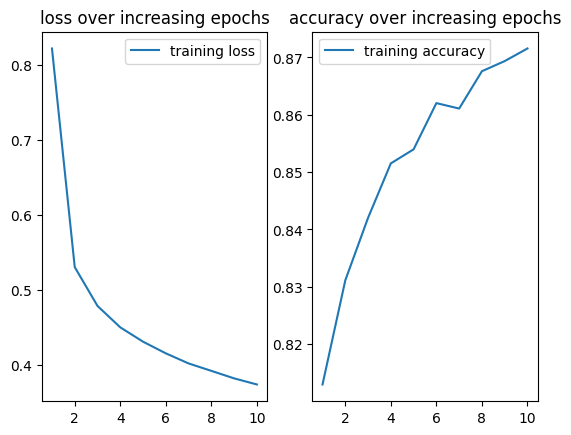

In [8]:
epochs = np.arange(10) + 1
plt.subplot(121)
plt.title('loss over increasing epochs')
plt.plot(epochs, losses, label='training loss')
plt.legend()
plt.subplot(122)
plt.title('accuracy over increasing epochs')
plt.plot(epochs, accuracies, label='training accuracy')
plt.legend()

## Varying Batch Size

In [9]:
# fetch datasset
class FmnistData(Dataset):
    def __init__(self, x, y):
        x = x.float()/255 # scale data
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)
        
# load dataset
def get_data():
    train = FmnistData(train_fmnist, target_fmnist)
    train_dl = DataLoader(train, batch_size=10000, shuffle=True) # batch size changed to 10000
    return train_dl

# define model
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10) # 10 classes
    ).to(device)
    # calculate loss
    loss_func = nn.CrossEntropyLoss()
    # optimizer
    optimizer = SGD(model.parameters(), lr=0.01)
    return model, loss_func, optimizer

# train batch
def train_batch(x, y, model, optimizer, loss_func):
    model.train()
    prediction = model(x)
    batch_loss = loss_func(prediction, y)
    batch_loss.backward()
    # weight update
    optimizer.step()
    # reset previous grads
    optimizer.zero_grad()
    return batch_loss.item()
    
# calculate accuracy
@torch.no_grad() # disable grads
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

# train the model after data scale
train_dl = get_data()
model, loss_func, optimizer = get_model()
losses, accuracies = [], []
for epoch in range(10):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    # training
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_func)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    # evaluation
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


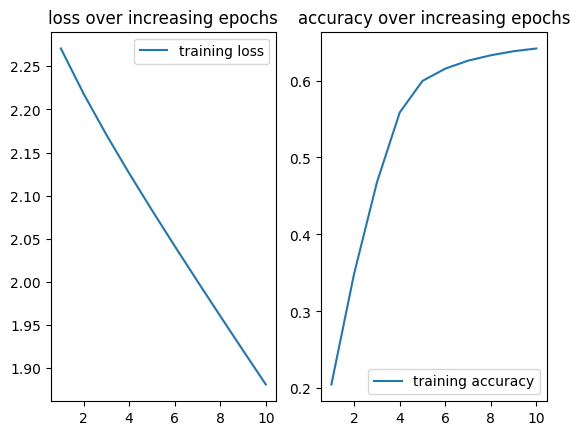

In [10]:
epochs = np.arange(10) + 1
plt.subplot(121)
plt.title('loss over increasing epochs')
plt.plot(epochs, losses, label='training loss')
plt.legend()
plt.subplot(122)
plt.title('accuracy over increasing epochs')
plt.plot(epochs, accuracies, label='training accuracy')
plt.legend()

## Varying Loss Optimizer

In [11]:
# fetch datasset
class FmnistData(Dataset):
    def __init__(self, x, y):
        x = x.float()/255 # scale data
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)
        
# load dataset
def get_data():
    train = FmnistData(train_fmnist, target_fmnist)
    train_dl = DataLoader(train, batch_size=10000, shuffle=True) # batch size changed to 10000
    return train_dl

# define model
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10) # 10 classes
    ).to(device)
    # calculate loss
    loss_func = nn.CrossEntropyLoss()
    # optimizer
    optimizer = Adam(model.parameters(), lr=0.01) # Adam Optimizer
    return model, loss_func, optimizer

# train batch
def train_batch(x, y, model, optimizer, loss_func):
    model.train()
    prediction = model(x)
    batch_loss = loss_func(prediction, y)
    batch_loss.backward()
    # weight update
    optimizer.step()
    # reset previous grads
    optimizer.zero_grad()
    return batch_loss.item()
    
# calculate accuracy
@torch.no_grad() # disable grads
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

# train the model after data scale
train_dl = get_data()
model, loss_func, optimizer = get_model()
losses, accuracies = [], []
for epoch in range(10):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    # training
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_func)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    # evaluation
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


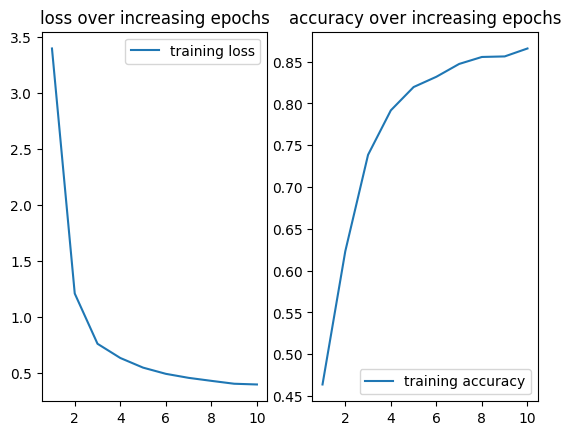

In [12]:
epochs = np.arange(10) + 1
plt.subplot(121)
plt.title('loss over increasing epochs')
plt.plot(epochs, losses, label='training loss')
plt.legend()
plt.subplot(122)
plt.title('accuracy over increasing epochs')
plt.plot(epochs, accuracies, label='training accuracy')
plt.legend()